In [326]:
import xarray as xr
import flox.xarray as fx
import numpy as np
import pandas as pd
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colormaps
import cartopy.crs as ccrs
import calendar

In [2]:
ds_globe = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/new_test.nc', chunks={'N_PROF':10000})

In [3]:
unique_prof = np.arange(len(ds_globe['N_PROF']))
ds_globe = ds_globe.assign_coords(N_PROF=('N_PROF', unique_prof))
ds_so = ds_globe.where(ds_globe.LATITUDE.compute()<-30, drop=True)

In [24]:
season_labels = {
    "DJF": "Summer",
    "MAM": "Autumn",
    "JJA": "Winter",
    "SON": "Spring"
}

**Look at Individual Profile**

In [230]:
prof = ds_so.isel(N_PROF=103)

In [10]:
ds_so = ds_so.assign_coords(season=("N_PROF", ds_so.TIME.dt.season.values))

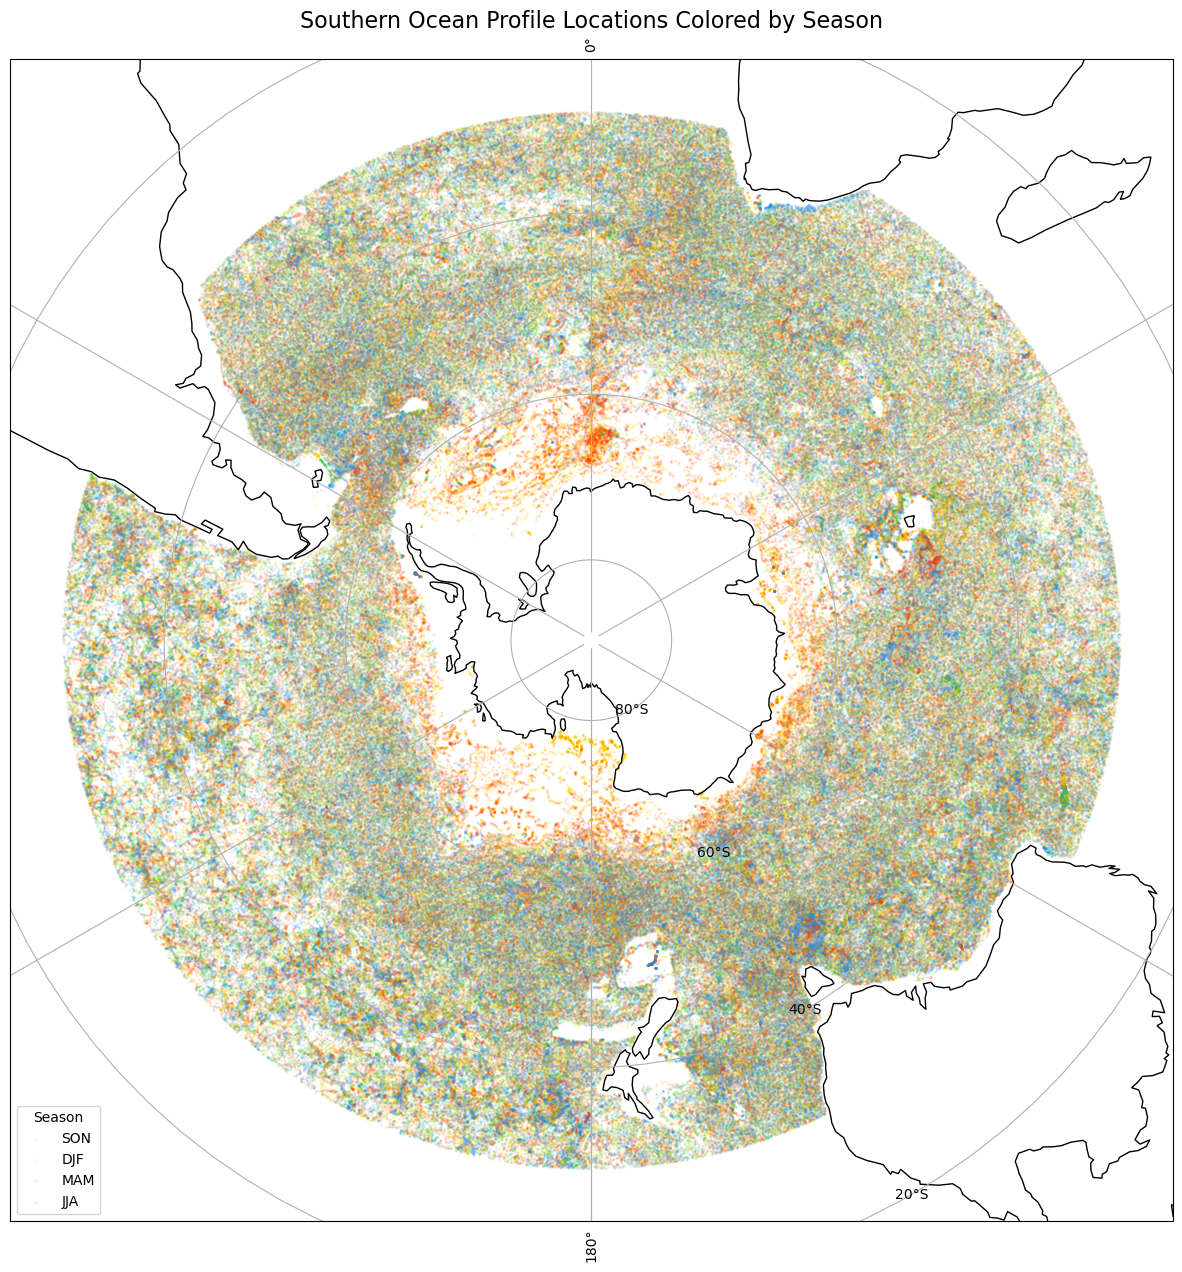

In [19]:
season_colors = {'SON': '#32CD32',
    'DJF': '#FFD700',    # gold
    'MAM': '#FF4500',    # orange red
    'JJA': '#1E90FF',    # blue
         # green
}
# Plot
fig = plt.figure(figsize=(15, 20))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
ax.gridlines(draw_labels=True)

# Plot each season
for season, color in season_colors.items():
    mask = ds_so.season == season
    ax.scatter(
        ds_so.LONGITUDE[mask],
        ds_so.LATITUDE[mask],
        transform=ccrs.PlateCarree(),
        color=color,
        s=1,
        label=season,
        alpha=0.1
    )

# Add legend
plt.legend(loc='lower left', title="Season")
plt.title("Southern Ocean Profile Locations Colored by Season", fontsize=16)
plt.show()

In [191]:
def calculate_ILD_bulk(ds, delta_temp=0.2):
    CT = ds.CT  # shape: (N_PROF, depth)
    P = ds.PRES_INTERPOLATED

    # Step 1: Reference temperature at 10m (fallback to 20m)
    T10 = CT.sel(PRES_INTERPOLATED=10, method='nearest')
    T20 = CT.sel(PRES_INTERPOLATED=20, method='nearest')

    # Where T10 is valid, use it; otherwise use T20
    valid_T10 = ~np.isnan(T10)
    T_ref = xr.where(valid_T10, T10, T20)
    ref_depth = xr.where(valid_T10, 10, 20)

    # Step 2: Broadcast threshold and ref_depth across all pressure levels
    threshold = T_ref - delta_temp
    threshold_b = threshold.broadcast_like(CT)
    ref_depth_b = ref_depth.broadcast_like(P)

    # Step 3: Apply mask for threshold crossing and depth condition
    mask = (CT < threshold_b) & (P > ref_depth_b)

    # Step 4: Find minimum depth where condition is met (ILD)
    masked_pres = P.where(mask)
    ild = masked_pres.min(dim='PRES_INTERPOLATED')

    return ild


In [251]:
ds_so['ILD'] = calculate_ILD_bulk(ds_so)

In [293]:
seasonal_groups = ds_so.groupby('TIME.season')

In [306]:
def get_ds_binned(ds, lon_bins, lat_bins):
    """
    Bin an xarray Dataset by 3-degree latitude and longitude bins,
    replacing Interval dimensions with bin centers.
    
    Parameters:
        ds : xarray.Dataset
            The dataset to bin.
        lon_bins : array-like
            Bin edges for longitude (e.g. np.arange(-180, 181, 3))
        lat_bins : array-like
            Bin edges for latitude (e.g. np.arange(-90, 91, 3))
    
    Returns:
        xarray.Dataset
            Binned dataset with dimensions (PRES_INTERPOLATED, lon_c, lat_c)
    """

    # Step 1: Bin with fx.xarray_reduce using IntervalIndex
    ds_binned = fx.xarray_reduce(
        ds,
        'LONGITUDE',
        'LATITUDE',
        func='mean',
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins),
        ),
        fill_value=np.nan,
        skipna=True
    )

    # Step 2: Create left, right, center arrays
    lon_l = np.array(lon_bins[:-1])
    lon_r = np.array(lon_bins[1:])
    lon_c = (lon_l + lon_r) / 2

    lat_l = np.array(lat_bins[:-1])
    lat_r = np.array(lat_bins[1:])
    lat_c = (lat_l + lat_r) / 2

    # Step 3: Replace Interval dims with center dims
    ds_binned = ds_binned.assign_coords({
        "lon_c": ("LONGITUDE", [iv.mid for iv in ds_binned['LONGITUDE'].values]),
        "lat_c": ("LATITUDE", [iv.mid for iv in ds_binned['LATITUDE'].values]),
        "lon_l": ("LONGITUDE", lon_l),
        "lon_r": ("LONGITUDE", lon_r),
        "lat_l": ("LATITUDE", lat_l),
        "lat_r": ("LATITUDE", lat_r),
    })

    ds_binned = ds_binned.swap_dims({"LONGITUDE": "lon_c", "LATITUDE": "lat_c"})

    return ds_binned

In [315]:
ds_so

<xarray.Dataset>
Dimensions:            (N_PROF: 656862, PRES_INTERPOLATED: 1001)
Coordinates:
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 0 2 4 6 ... 1994 1996 1998 2000
  * N_PROF             (N_PROF) int64 5879 5880 5881 ... 2550893 2550894 2550895
    TIME               (N_PROF) datetime64[ns] 2006-04-15T13:51:43 ... 2025-0...
    LATITUDE           (N_PROF) float64 -42.64 -42.65 -42.76 ... -42.19 -40.33
    LONGITUDE          (N_PROF) float64 -4.772 -4.579 -4.508 ... -142.5 -141.7
    season             (N_PROF) <U3 'MAM' 'MAM' 'MAM' ... 'DJF' 'MAM' 'MAM'
Data variables: (12/13)
    CT                 (N_PROF, PRES_INTERPOLATED) float64 dask.array<chunksize=(3631, 1001), meta=np.ndarray>
    CYCLE_NUMBER       (N_PROF) float64 dask.array<chunksize=(3631,), meta=np.ndarray>
    DATA_MODE          (N_PROF) object dask.array<chunksize=(3631,), meta=np.ndarray>
    DIRECTION          (N_PROF) object dask.array<chunksize=(3631,), meta=np.ndarray>
    PLATFORM_NUMBER    (N_PROF) float64 dask.array<chunksize=(3631,), meta=np.ndarray>
    PRES               (N_PROF, PRES_INTERPOLATED) float32 dask.array<chunksize=(3631, 1001), meta=np.ndarray>
    ...                 ...
    SA                 (N_PROF, PRES_INTERPOLATED) float64 dask.array<chunksize=(3631, 1001), meta=np.ndarray>
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 dask.array<chunksize=(3631, 1001), meta=np.ndarray>
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 dask.array<chunksize=(3631, 1001), meta=np.ndarray>
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 dask.array<chunksize=(3631, 1001), meta=np.ndarray>
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 dask.array<chunksize=(3631, 1001), meta=np.ndarray>
    ILD                (N_PROF) float64 dask.array<chunksize=(3631,), meta=np.ndarray>
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          https://data-argo.ifremer.fr/dac/coriolis/6903068/6...
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [307]:
lon_bins = np.arange(-180,181,1)
so_lat_bins = np.arange(-90,-29,1)

In [316]:
seasonal_groups = ds_so.groupby('TIME.season')

ds_so_ild_seasonal = {
    season: get_ds_binned(group, lon_bins, so_lat_bins)['ILD'].compute()
    for season, group in seasonal_groups
}

/home.ufs/jp4778/.conda/envs/pangeo/lib/python3.10/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/home.ufs/jp4778/.conda/envs/pangeo/lib/python3.10/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/home.ufs/jp4778/.conda/envs/pangeo/lib/python3.10/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)
/home.ufs/jp4778/.conda/envs/pangeo/lib/python3.10/site-packages/dask/array/reductions.py:611: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


In [318]:
ordered_seasons = ["DJF", "MAM", "JJA", "SON"]
season_labels = {
    "DJF": "Summer",
    "MAM": "Autumn",
    "JJA": "Winter",
    "SON": "Spring"
}

/tmp/ipykernel_61675/110877638.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


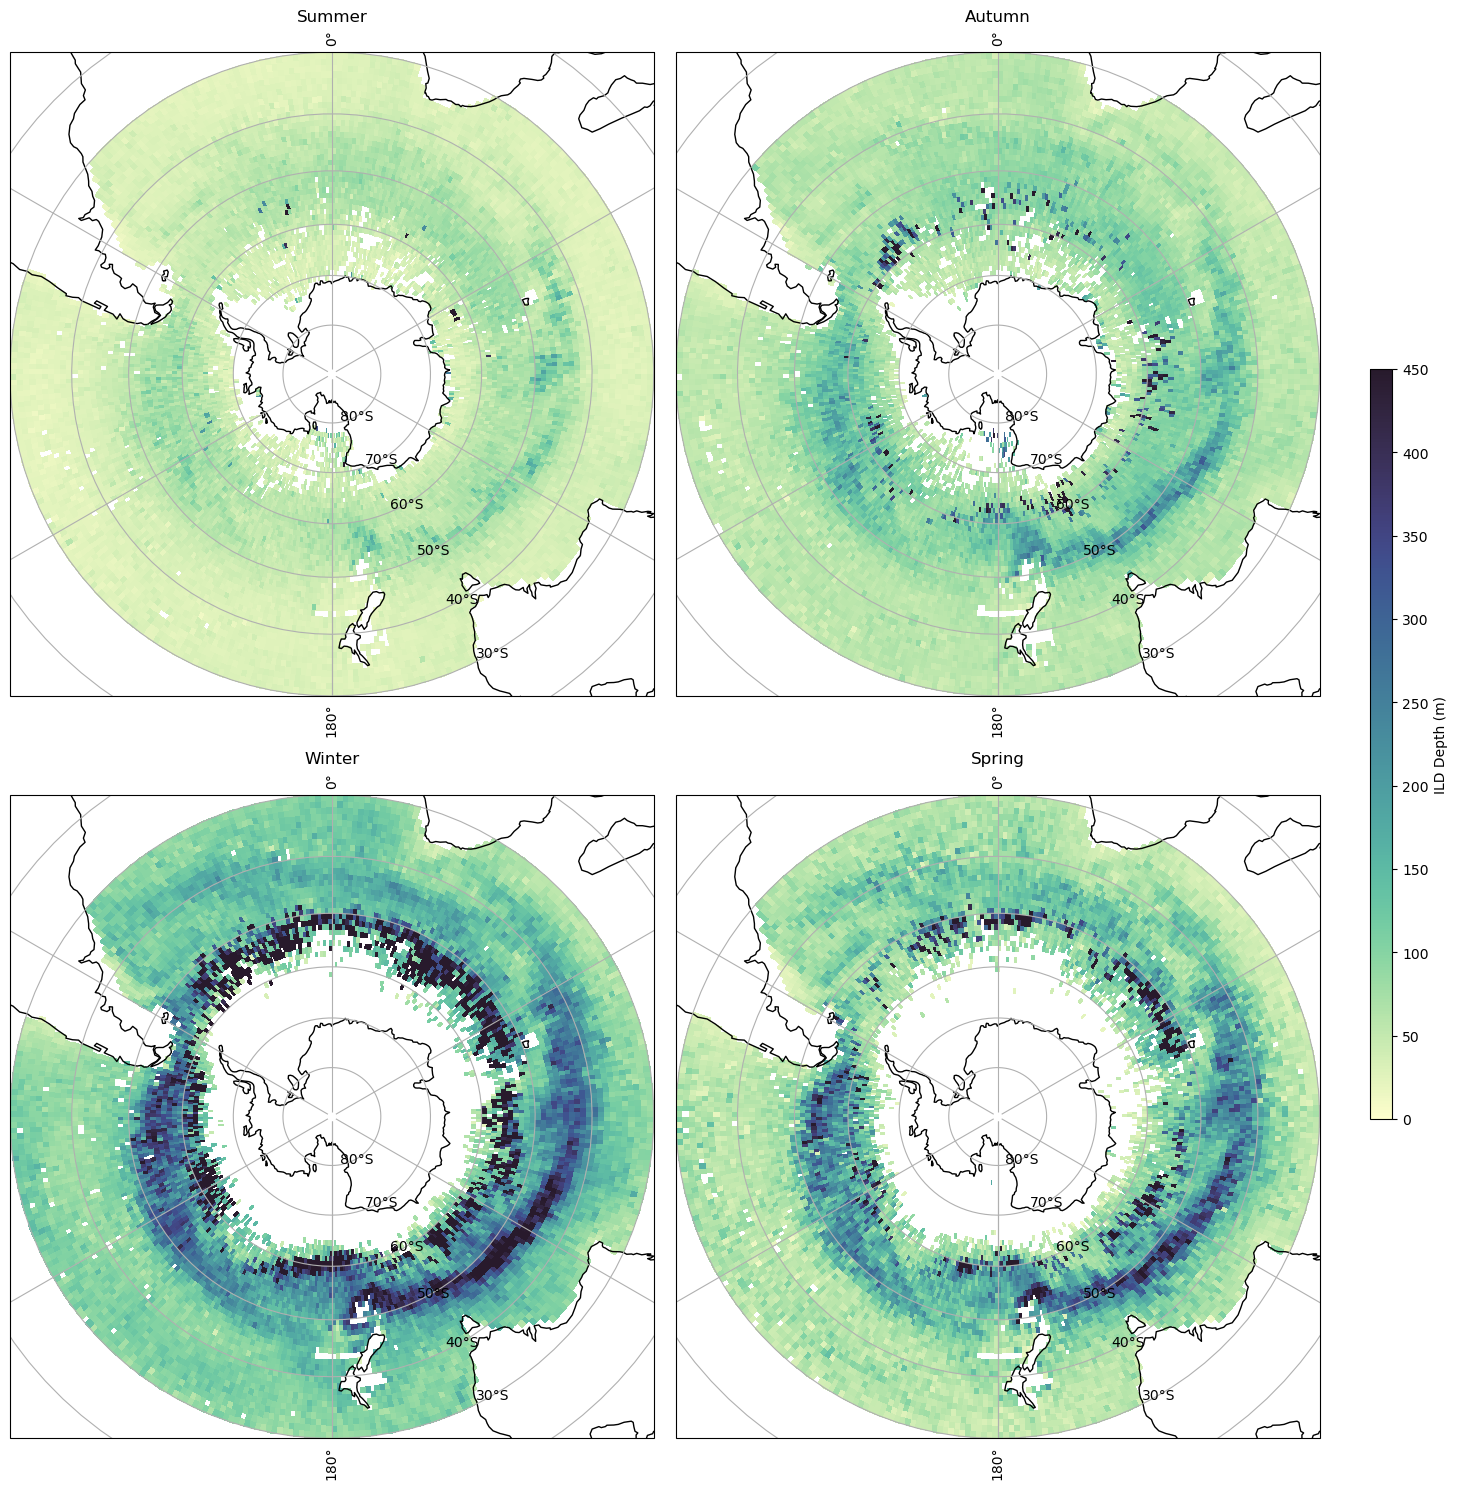

In [363]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), 
                        subplot_kw={'projection': ccrs.SouthPolarStereo()})
axs = axs.ravel()

for i, season in enumerate(ordered_seasons):
    ds = ds_so_ild_seasonal[season]
    ax = axs[i]
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Plot with consistent color limits
    ds.plot(
        ax=ax,
        x='lon_c',
        y='lat_c',
        transform=ccrs.PlateCarree(),
        vmin=0,
        vmax=450,
        cmap=cmo.deep,
        add_colorbar=False
    )
    ax.set_title(season_labels[season])
    
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
plt.colorbar(axs[0].collections[0], cax=cbar_ax, label="ILD Depth (m)")

plt.tight_layout(rect=[0, 0, 0.9, 1])

In [335]:
prof = ds_so.isel(N_PROF=300)

In [352]:
target_lat = -50    # 50°S (negative for Southern Hemisphere)
target_lon = 120    # 120°E
lat_buffer = 2      # ±2° latitude tolerance
lon_buffer = 5      # ±5° longitude tolerance (wider if needed)


filtered_ds = ds_so.where(
    (ds_so['TIME.season'] == 'JJA') &                  # Winter season
    (ds_so['LATITUDE'] >= target_lat - lat_buffer) &   # Latitude lower bound
    (ds_so['LATITUDE'] <= target_lat + lat_buffer) &   # Latitude upper bound
    (ds_so['LONGITUDE'] >= target_lon - lon_buffer) &  # Longitude lower bound
    (ds_so['LONGITUDE'] <= target_lon + lon_buffer),   # Longitude upper bound
    drop=True  # Drop NaN values (profiles outside criteria)
)

In [355]:
prof = filtered_ds.isel(N_PROF = 20)

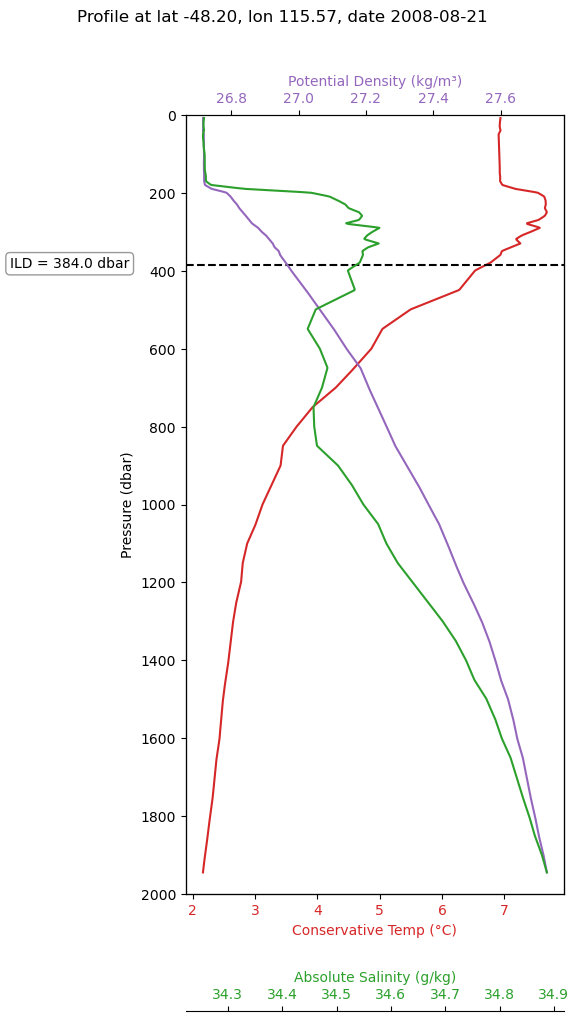

In [361]:
y = prof.PRES_INTERPOLATED

# Base axis (CT)
fig, ax_ct = plt.subplots(figsize=(6, 10))
ax_ct.invert_yaxis()
ax_ct.plot(prof.CT, y, color='tab:red')
ax_ct.set_xlabel("Conservative Temp (°C)", color='tab:red')
ax_ct.set_ylabel("Pressure (dbar)")
ax_ct.tick_params(axis='x', labelcolor='tab:red')

# Set y-axis ticks from 0 to 2000 at 200 intervals
ax_ct.set_yticks(np.arange(0, 2001, 200))  # 0, 200, 400,..., 2000

# Add ILD line
ild = prof.ILD.values.item()
ax_ct.axhline(y=ild, color='k', linestyle='--', linewidth=1.5,
             label=f'ILD ({ild:.1f} dbar)')
ax_ct.text(
    x=0.98,  # Right edge of plot (98% of x-axis range)
    y=ild - 20,  # 20 dbar below the ILD line (adjust offset as needed)
    s=f'ILD = {ild:.1f} dbar',
    ha='right',  # Right-aligned text
    va='top',  # Text sits above the y-position
    bbox=dict(
        boxstyle='round,pad=0.3',
        facecolor='white',
        edgecolor='gray',
        alpha=0.8
    ),
    fontsize=10
)

# Top axis (SIG0)
ax_sig0 = ax_ct.twiny()
ax_sig0.plot(prof.SIG0, y, color='tab:purple')
ax_sig0.set_xlabel("Potential Density (kg/m³)", color='tab:purple')
ax_sig0.tick_params(axis='x', labelcolor='tab:purple')

# Third axis (SA)
ax_sa = ax_ct.twiny()
ax_sa.spines["top"].set_position(("axes", -0.15))
ax_sa.plot(prof.SA, y, color='tab:green')
ax_sa.set_xlabel("Absolute Salinity (g/kg)", color='tab:green')
ax_sa.tick_params(axis='x', labelcolor='tab:green')
ax_sa.xaxis.set_label_position('top')
ax_sa.xaxis.set_ticks_position('top')

# Adjust CT axis labels
ax_ct.xaxis.set_label_position('bottom')
ax_ct.xaxis.set_ticks_position('bottom')

ax_ct.set_ylim(2000, 0)

# Title
plt.suptitle(
    'Profile at lat {:.2f}, lon {:.2f}, date {}'.format(
        prof.LATITUDE.values,
        prof.LONGITUDE.values,
        np.datetime_as_string(prof.TIME.values, unit='D')
    ),
    y=1.02
)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'SO Profiles with Profile in Summer')

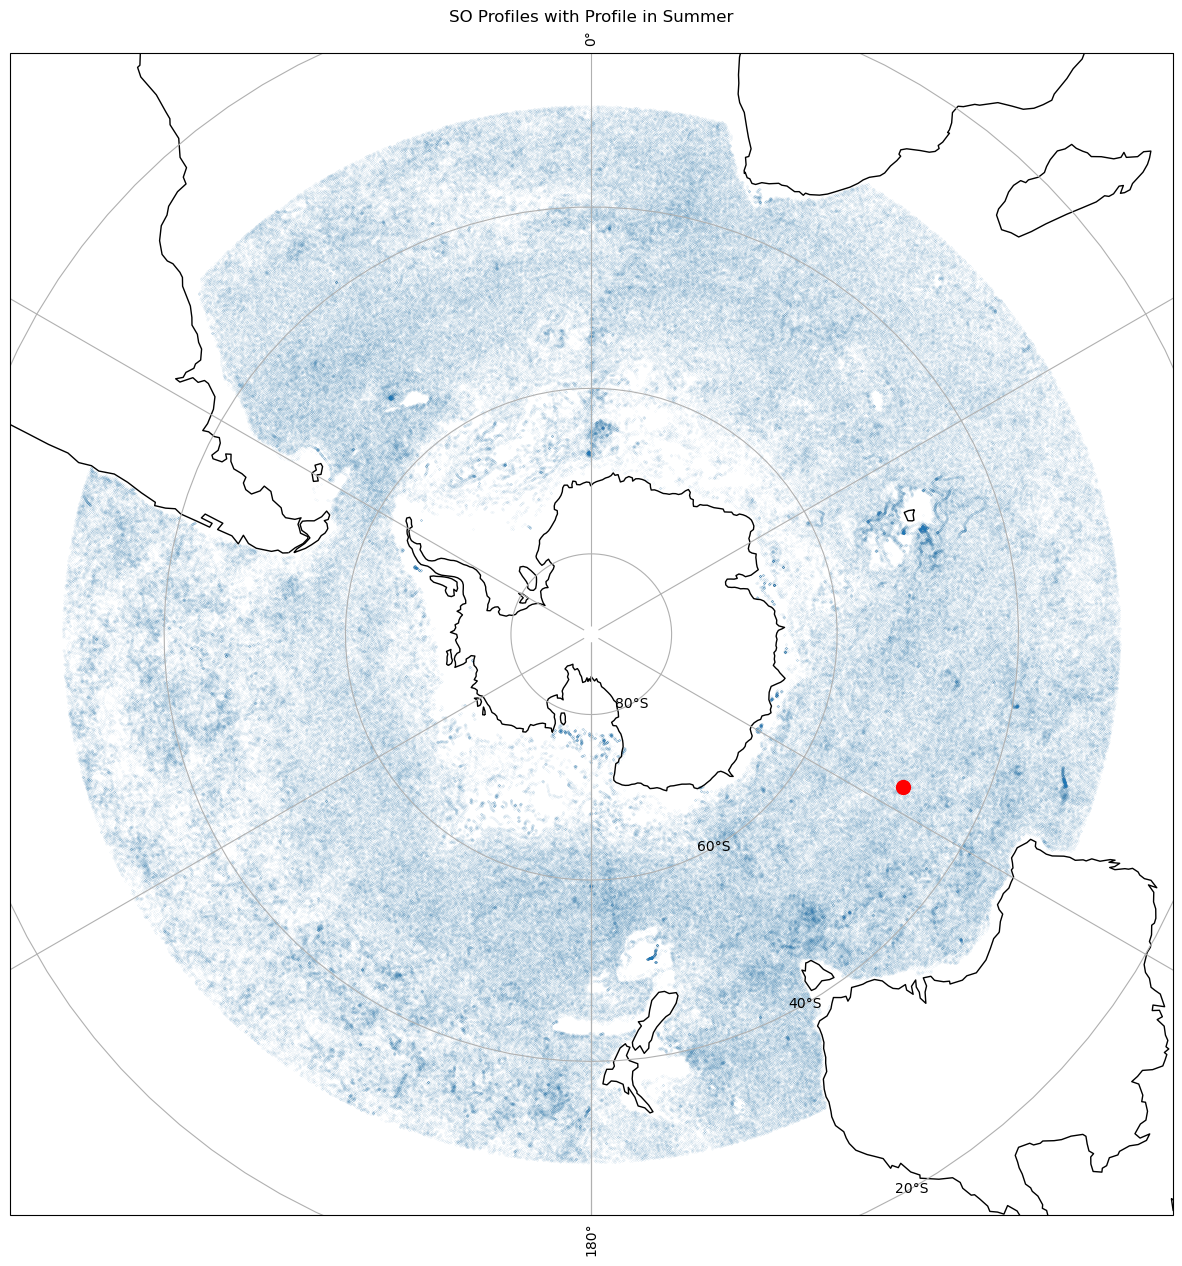

In [350]:
fig = plt.figure(figsize=(15, 20))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.scatter(ds_so.LONGITUDE,ds_so.LATITUDE,transform=ccrs.PlateCarree(),color='tab:blue',s=0.001)
ax.scatter(prof.LONGITUDE,prof.LATITUDE,transform=ccrs.PlateCarree(),color='r',s=100)
plt.title(f'SO Profiles with Profile in {season_labels[prof.TIME.dt.season.item()]}')